In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from boruta import BorutaPy
import optuna
import math

In [239]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

# Data

## Load

In [3]:
data_train = pd.read_csv('/home/yashima/ML/Kaggle/GettingStart/HousePrices/data/train.csv')
x_test = pd.read_csv('/home/yashima/ML/Kaggle/GettingStart/HousePrices/data/test.csv')
pd.set_option('display.max_columns', 90)

In [4]:
print(data_train.shape)
data_train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(x_test.shape)
x_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Analyse

### About Target

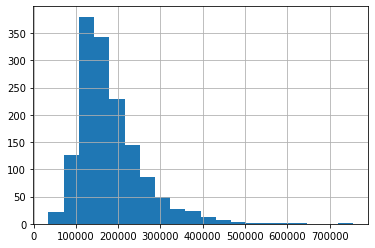

In [6]:
prices = data_train.SalePrice.hist(bins=20)

This histogram seems Distorted distribution to the right. So, It may be Lognormal distribution.

### About Features

In [7]:
data_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

---
Type 'object' has to be encoded numerical. 

# Preprocess

## Split data

In [8]:
_data_train = copy.deepcopy(data_train)
_x_test = copy.deepcopy(x_test)

In [9]:
x_train = _data_train.drop(['Id', 'SalePrice'], axis=1)
y_train = _data_train.SalePrice
id_test = _x_test.Id
x_test = _x_test.drop(['Id'], axis=1)

## Fix scale

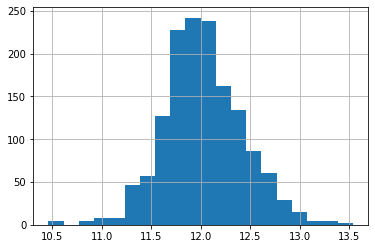

In [10]:
y_train_fix = np.log1p(y_train)
y_train_fix.hist(bins=20)

In this case, use y_train_fix as lognormal distribution.

## Cleaning

### Fill NaN

In [11]:
def  detect_nan(data):
    cols_isnan = []
    cols_isnan_set = []
    for i, isnan in enumerate(data.isnull().any()):
        if isnan is True:
            cols_isnan.append(data.columns[i])
            cols_isnan_set.append((data.columns[i], data.dtypes[i]))
    return cols_isnan, cols_isnan_set

In [12]:
train_cols_isnan, train_cols_isnan_set = detect_nan(x_train)
test_cols_isnan, test_cols_isnan_set = detect_nan(x_test)

In [13]:
train_cols_isnan_set

[('LotFrontage', dtype('float64')),
 ('Alley', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),
 ('BsmtFinType2', dtype('O')),
 ('Electrical', dtype('O')),
 ('FireplaceQu', dtype('O')),
 ('GarageType', dtype('O')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageFinish', dtype('O')),
 ('GarageQual', dtype('O')),
 ('GarageCond', dtype('O')),
 ('PoolQC', dtype('O')),
 ('Fence', dtype('O')),
 ('MiscFeature', dtype('O'))]

In [14]:
test_cols_isnan_set

[('MSZoning', dtype('O')),
 ('LotFrontage', dtype('float64')),
 ('Alley', dtype('O')),
 ('Utilities', dtype('O')),
 ('Exterior1st', dtype('O')),
 ('Exterior2nd', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),
 ('BsmtFinSF1', dtype('float64')),
 ('BsmtFinType2', dtype('O')),
 ('BsmtFinSF2', dtype('float64')),
 ('BsmtUnfSF', dtype('float64')),
 ('TotalBsmtSF', dtype('float64')),
 ('BsmtFullBath', dtype('float64')),
 ('BsmtHalfBath', dtype('float64')),
 ('KitchenQual', dtype('O')),
 ('Functional', dtype('O')),
 ('FireplaceQu', dtype('O')),
 ('GarageType', dtype('O')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageFinish', dtype('O')),
 ('GarageCars', dtype('float64')),
 ('GarageArea', dtype('float64')),
 ('GarageQual', dtype('O')),
 ('GarageCond', dtype('O')),
 ('PoolQC', dtype('O')),
 ('Fence', dtype('O')),
 ('MiscFeature', dtype('O')),
 ('SaleT

In [15]:
cols_isnan = train_cols_isnan+test_cols_isnan
cols_isnan_set = train_cols_isnan_set+test_cols_isnan_set
types = [column[1] for column in cols_isnan_set]
uniques = set(types)
uniques

{dtype('float64'), dtype('O')}

In [16]:
def filled(data, cols):
    data_filled = copy.deepcopy(data)
    new_cols = [column+'_filled' for column in cols]
    for i, new_column in enumerate(new_cols):
        data_filled[new_column] = 0
        data_filled.loc[data_filled[cols[i]]!=data_filled[cols[i]], new_column] = 1
    data_filled['IsNaN'] = 0
    for index in range(len(data_filled)):
        if data_filled.iloc[index].isnull().any():
            data_filled['IsNaN'] = 1
    
    for column in cols:
        if data_filled[column].dtype=='object': 
            data_filled[column] = data_filled[column].fillna('NotAvailable')
        if data_filled[column].dtype=='float64':
            concat = pd.concat([x_train[column], x_test[column]])
            median = concat.median()
            data_filled[column] = data_filled[column].fillna(median)           
    return data_filled

In [17]:
x_train_filled = filled(x_train, cols_isnan)
x_test_filled = filled(x_test, cols_isnan)
x_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_filled,Alley_filled,MasVnrType_filled,MasVnrArea_filled,BsmtQual_filled,BsmtCond_filled,BsmtExposure_filled,BsmtFinType1_filled,BsmtFinType2_filled,Electrical_filled,FireplaceQu_filled,GarageType_filled,GarageYrBlt_filled,GarageFinish_filled,GarageQual_filled,GarageCond_filled,PoolQC_filled,Fence_filled,MiscFeature_filled,MSZoning_filled,Utilities_filled,Exterior1st_filled,Exterior2nd_filled,BsmtFinSF1_filled,BsmtFinSF2_filled,BsmtUnfSF_filled,TotalBsmtSF_filled,BsmtFullBath_filled,BsmtHalfBath_filled,KitchenQual_filled,Functional_filled,GarageCars_filled,GarageArea_filled,SaleType_filled,IsNaN
0,60,RL,65.0,8450,Pave,NotAvailable,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,2,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,20,RL,80.0,9600,Pave,NotAvailable,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,5,2007,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,60,RL,68.0,11250,Pave,NotAvailable,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,9,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,70,RL,60.0,9550,Pave,NotAvailable,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,2,2006,WD,Abnorml,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,60,RL,84.0,14260,Pave,NotAvailable,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,...,0,0,NotAvailable,NotAvailable,NotAvailable,0,12,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Encord categorical to numeric

In [18]:
cols_cat = [column for column in x_train_filled.columns \
                     if x_train_filled[column].dtype=='object']

In [20]:
encoders = {}
for column in cols_cat:
    encoders[column] = LabelEncoder()
    val = x_train_filled[column].tolist()
    val.extend(x_test_filled[column].tolist())
    encoders[column].fit(val)
    x_train_filled[column] = encoders[column].transform(x_train_filled[column])+1
    x_test_filled[column] = encoders[column].transform(x_test_filled[column])+1

In [21]:
x_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_filled,Alley_filled,MasVnrType_filled,MasVnrArea_filled,BsmtQual_filled,BsmtCond_filled,BsmtExposure_filled,BsmtFinType1_filled,BsmtFinType2_filled,Electrical_filled,FireplaceQu_filled,GarageType_filled,GarageYrBlt_filled,GarageFinish_filled,GarageQual_filled,GarageCond_filled,PoolQC_filled,Fence_filled,MiscFeature_filled,MSZoning_filled,Utilities_filled,Exterior1st_filled,Exterior2nd_filled,BsmtFinSF1_filled,BsmtFinSF2_filled,BsmtUnfSF_filled,TotalBsmtSF_filled,BsmtFullBath_filled,BsmtHalfBath_filled,KitchenQual_filled,Functional_filled,GarageCars_filled,GarageArea_filled,SaleType_filled,IsNaN
0,60,5,65.0,8450,2,2,4,4,1,5,1,6,3,3,1,6,7,5,2003,2003,2,2,14,15,2,196.0,3,5,3,3,5,4,3,706,7,0,150,856,2,1,2,6,856,854,0,...,0,0,4,5,2,0,2,2008,10,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,20,5,80.0,9600,2,2,4,4,1,3,1,25,2,3,1,3,6,8,1976,1976,2,2,9,9,3,0.0,4,5,2,3,5,2,1,978,7,0,284,1262,2,1,2,6,1262,0,0,...,0,0,4,5,2,0,5,2007,10,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,60,5,68.0,11250,2,2,1,4,1,5,1,6,3,3,1,6,7,5,2001,2002,2,2,14,15,2,162.0,3,5,3,3,5,3,3,486,7,0,434,920,2,1,2,6,920,866,0,...,0,0,4,5,2,0,9,2008,10,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,70,5,60.0,9550,2,2,1,4,1,1,1,7,3,3,1,6,7,5,1915,1970,2,2,15,17,3,0.0,4,5,1,5,2,4,1,216,7,0,540,756,2,3,2,6,961,756,0,...,0,0,4,5,2,0,2,2006,10,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,60,5,84.0,14260,2,2,1,4,1,3,1,16,3,3,1,6,8,5,2000,2000,2,2,14,15,2,350.0,3,5,3,3,5,1,3,655,7,0,490,1145,2,1,2,6,1145,1053,0,...,0,0,4,5,2,0,12,2008,10,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Feature Engineering

### ReAnalysis

In [250]:
df_train = copy.deepcopy(x_train_filled)
# df_train['SalePrice'] = y_train_fix
df_test = copy.deepcopy(x_test_filled)

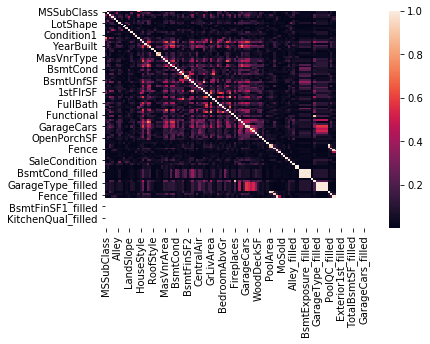

In [215]:
corr = df_train.corr(method='pearson').abs()
sns.heatmap(corr)

### Filter Method

#### Reject variance 0

In [251]:
sel  = VarianceThreshold(threshold=0)
sel.fit(df_train)
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

---
Reject features which variance is 0 (i.e. same value) in train data.

In [252]:
df_train = df_train.loc[:, sel.get_support()]
df_test = df_test.loc[:, sel.get_support()]

#### Reject variance 0.1

In [253]:
sel = VarianceThreshold(threshold=0.1)
sel.fit(df_train)
sel.get_support()

array([ True,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False])

---
Reject features which variance is 0.1 (i.e. about 99% is same value) in train data.

In [254]:
df_train = df_train.loc[:, sel.get_support()]
df_test = df_test.loc[:, sel.get_support()]

#### Reject high correlation coefficient

In [129]:
# corr_matrix = df_train.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
#                                                   k=1).astype(np.bool))
# cols_to_drop = [column for column in upper.columns
#                               if any(upper[column] > 0.8)]

In [130]:
# df_train = df_train.drop(cols_to_drop, axis=1)
# df_test = df_test.drop(cols_to_drop, axis=1)

#### Matual Information

In [220]:
mi = mutual_info_regression(df_train, y_train_fix)
mi = pd.Series(mi)
mi.index = df_train.columns

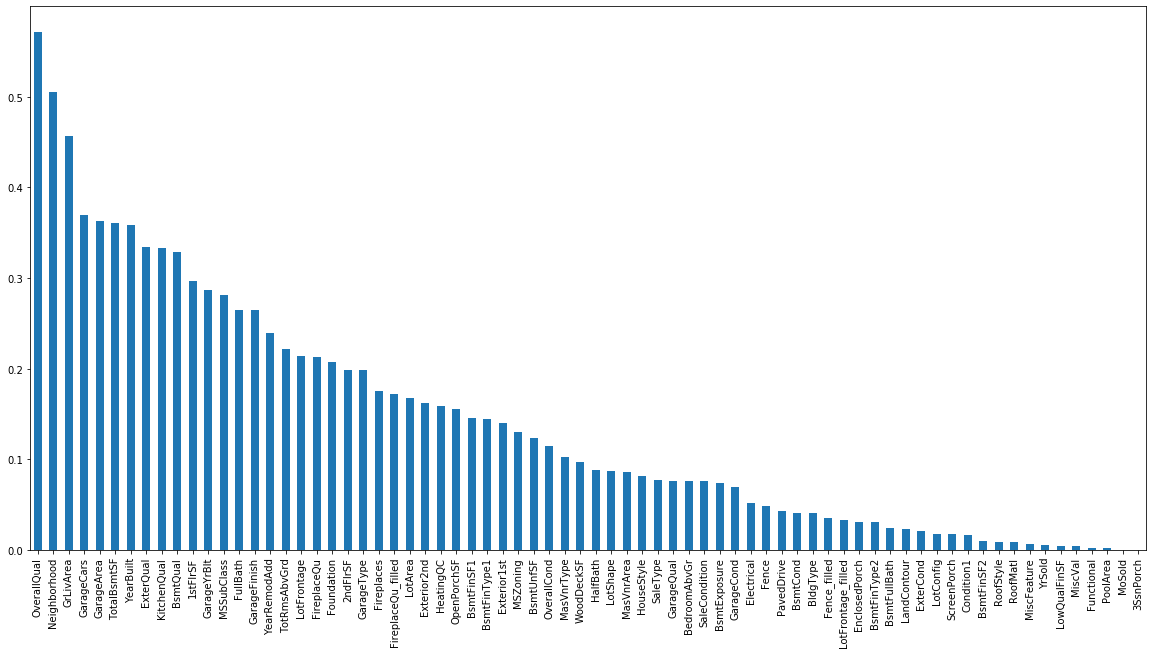

In [221]:
mi.sort_values(ascending=False).plot(kind='bar', figsize=(20,10))

# Learn

## Optuna

In [265]:
def rmse_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

In [266]:
def objective(trial):
    # Booster Parameters
    eta = trial.suggest_discrete_uniform('eta', 0.1, 0.9, 0.1)
    gamma = trial.suggest_discrete_uniform('gamma', 0.01, 0.20, 0.02)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        random_state=1,
        eta=eta,
        gamma=gamma,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample
    )
    
    kf = KFold(5, shuffle=True, random_state=1).get_n_splits(x_train_filled)
    score_funcs = {
        'rmse': make_scorer(rmse_score),
    }
    scores = cross_validate(model,
                                                df_train.to_numpy(), y_train_fix.to_numpy(),
                                                cv=kf, scoring=score_funcs,
                                                verbose=0)
    
    return scores['test_rmse'].mean()

In [ ]:
study = optuna.create_study()
study.optimize(func=objective,
                            n_trials=100, 
                            timeout=None, 
                             n_jobs=-1)

[W 2019-12-08 20:57:58,082] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[W 2019-12-08 20:57:58,083] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[W 2019-12-08 20:57:58,084] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[W 2019-12-08 20:57:58,085] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[I 2019-12-08 20:58:38,445] Finished trial#1 resulted in value: 0.1290782685557917. Current best value is 0.1290782685557917 with parameters: {'eta': 0.7000000000000001, 'gamma': 0.05, 'max_depth': 6, 'min_child_weight': 17, 'subsample': 0.7}.
[W 2019-12-08 20:58:38,450] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[I 2019-12-08 20:58:51,153] Finished trial#3 resulted in value: 0.13051758762599644. Current best value is 0.1290782685557917 with parameters: {'eta': 0.7000000000000001, 

[I 2019-12-08 21:02:41,721] Finished trial#21 resulted in value: 0.12902775680542874. Current best value is 0.12884228465633996 with parameters: {'eta': 0.8, 'gamma': 0.06999999999999999, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6}.
[W 2019-12-08 21:02:41,747] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[I 2019-12-08 21:02:52,288] Finished trial#22 resulted in value: 0.12847945501176086. Current best value is 0.12847945501176086 with parameters: {'eta': 0.8, 'gamma': 0.05, 'max_depth': 8, 'min_child_weight': 14, 'subsample': 0.5}.
[W 2019-12-08 21:02:52,314] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.01, 0.19].
[I 2019-12-08 21:03:17,650] Finished trial#23 resulted in value: 0.1291837871195835. Current best value is 0.12847945501176086 with parameters: {'eta': 0.8, 'gamma': 0.05, 'max_depth': 8, 'min_child_weight': 14, 'subsample': 0.5}.
[W 2019-12-08 21:03:17,679] The range of parameter `gamma

## Create Model

In [208]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    random_state=1,
    eta=0.07
)

## Boruta

In [209]:
# rfr = RandomForestRegressor()
# feat_selecotr = BorutaPy(
#     rfr,
#     n_estimators='auto',
#     alpha=0.05,
#     two_step=False,
#     verbose=2,
#     perc=80,
#     max_iter=150
# )
# feat_selecotr.fit(df_train.to_numpy(), y_train_fix.to_numpy())

Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	9 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	10 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	11 / 150
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	12 / 150
Confirmed: 	62
Tentative: 	8
Rejected: 	44
Iteration: 	13 / 150
Confirmed: 	62
Tentative: 	8
Rejected: 	44
Iteration: 	14 / 150
Confirmed: 	62
Tentative: 	8
Rejected: 	44
Iteration: 	15 / 150
Confirmed: 	62
Tentative: 	8
Rejected: 	44
Iteration: 	16 / 150
Confirmed: 	62
Tentative: 	6

Iteration: 	129 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	130 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	131 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	132 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	133 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	134 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	135 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	136 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	137 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	138 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	139 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	140 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	141 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	142 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	143 / 150
Confirmed: 	62
Tentative: 	1
Rejected: 	51
Iteration: 	144 / 150
Con

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=None, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=112, n_jobs=None,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x7f2256c54360>,
                                         verbose=0, warm_start=False),
         max_iter=150, n_estimators='auto', perc=50,
         random_state=<mtrand.RandomState object at 0x7f2256c54360>,
         two_

In [210]:
# df_train = df_train.loc[:, feat_selecotr.support_]

## Fit

In [211]:
kf = KFold(5, shuffle=True, random_state=1).get_n_splits(df_train)
rmse = np.sqrt(-cross_val_score(model, df_train,y_train_fix,
                                                            scoring="neg_mean_squared_error",
                                                            cv=kf, verbose=0))
model.fit(df_train, y_train_fix)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [89]:
kf = KFold(5, shuffle=True, random_state=1).get_n_splits(x_train_filled)
rmse = np.sqrt(-cross_val_score(model, x_train_filled,y_train_fix,
                                                            scoring="neg_mean_squared_error",
                                                            cv=kf, verbose=0))
model.fit(x_train_filled, y_train_fix)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [212]:
print('---RMSE---')
print('CROSS : {}'.format(rmse))
print('MEAN : {}'.format(rmse.mean()))

---RMSE---
CROSS : [0.11041837 0.14707273 0.13140377 0.11657295 0.12933399]
MEAN : 0.12696036234481176


In [31]:
pred = np.expm1(model.predict(x_test_filled))
print(pred[:5])

[123993.21 165304.67 190860.2  194109.28 182561.72]


# Submit

In [32]:
submit = pd.DataFrame({'Id':id_test, 'SalePrice':pred})
submit.to_csv('../data/submission_xgboost.csv', index=False)